In [897]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/masterskaya/kaggle_startups_train_28062024.csv
/kaggle/input/masterskaya/kaggle_startups_test_28062024.csv


**Проект: Мастерская-1. Предсказание успешности стартапов.**

**Описание исследования**

В этом исследовании предстоит работать с псевдо-реальными данными о стартапах (реальные данные в которые добавлена синтетическая составляющая), функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются.

**Цель исследования**

Разработать решение, которое позволит помочь клиенту выгодно инвестировать в стартапы.

**Задача исследования**

Разработать модель для предсказания успешности стартапа (закроется или нет).

**Исходные данные**

В распоряжении два датасета: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

Файл kaggle_startups_train_01.csv содержит данные о (53 000) стартапах, которые будут использоваться в качестве обучающих данных. Файл kaggle_startups_test_01.csv содержит данные о (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Задача - предсказать значение 'status' для каждого стартапа из этого датасета.

**Описание полей данных:**
name - Название стартапа.
category_list - Список категорий, к которым относится стартап.
funding_total_usd - Общая сумма финансирования в USD.
status - Статус стартапа (закрыт или действующий).
country_code - Код страны.
state_code - Код штата.
region - Регион.
city - Город.
funding_rounds - Количество раундов финансирования.
founded_at - Дата основания.
first_funding_at - Дата первого раунда финансирования.
last_funding_at - Дата последнего раунда финансирования.
closed_at - Дата закрытия стартапа (если применимо).

In [898]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import math
import sklearn

from scipy import stats as st
from math import factorial
from scipy.stats import binom

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import(
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    RobustScaler
)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures,
    LabelEncoder
)


from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier

import category_encoders as ce
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    fbeta_score,
    roc_curve,
    roc_auc_score,
    RocCurveDisplay,
    make_scorer
)

import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay

from itertools import combinations
from scipy.spatial.distance import euclidean,cityblock

from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge

from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif 


import time
from scipy.stats import pearsonr
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


import warnings
warnings.filterwarnings("ignore")           
import shap

In [899]:
dates_columns_train = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']

In [900]:
startups_train = pd.read_csv('/kaggle/input/masterskaya/kaggle_startups_train_28062024.csv', decimal=',', parse_dates=dates_columns_train)

In [901]:
startups_train.sample(5)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
27179,Cognition Health Partners,Biotechnology,1639000.0,operating,USA,FL,Panama City,Panama City Beach,1,2010-01-01,2012-09-18,2012-09-18,NaT
42280,FluxBand,Consumer Electronics|Health Care|Personal Heal...,NaN,operating,USA,CA,SF Bay Area,Sunnyvale,1,2014-05-01,2014-12-15,2014-12-15,NaT
28951,Lutz Convenience Food,Consumers,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-21,2014-05-19,2014-05-19,2016-01-20
47532,Stumpedia,Social Media,100000.0,operating,NaN,NaN,NaN,NaN,1,2008-01-01,2008-01-01,2008-01-01,NaT
30400,LumiGrow,Hardware + Software,500000.0,operating,USA,CA,SF Bay Area,Novato,2,2009-11-29,2011-07-12,2012-12-06,NaT


In [902]:
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  object        
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), int64(1), object(8)
memory usage: 5.2+ 

In [903]:
dates_columns_test = ['first_funding_at', 'last_funding_at']

In [904]:
startups_test = pd.read_csv('/kaggle/input/masterskaya/kaggle_startups_test_28062024.csv', decimal=',', parse_dates=dates_columns_test)

In [905]:
startups_test.sample(5)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
12752,Sendyou Inc.,Apps,560625.0,JPN,40,Tokyo,Tokyo,1,2014-10-22,2014-10-22,1445
3243,ClearTracks,Cloud-Based Music|Music|Music Services,NaN,USA,NY,New York City,New York,1,2005-11-15,2005-11-15,1096
9774,Rouge Reel,Beauty|Cosmetics|E-Commerce|Video on Demand,182000.0,IRL,7,Dublin,Dublin,2,2014-04-04,2014-12-09,1445
9127,Afferent Pharmaceuticals,Biotechnology,89200000.0,USA,CA,SF Bay Area,San Mateo,7,2003-08-29,2015-07-08,3287
10406,Dogecoin,Curated Web|Internet,30000.0,SWE,7,NaN,NaN,1,2014-01-20,2014-01-20,1826


In [906]:
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  object        
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 1.1+ MB


Данные датасетов загружены, признаки соответствуют описанию.

**Предобработка данных**

In [907]:
def check_df(df):
    """
    Проверяет pandas DataFrame на наличие пропущенных значений и дубликатов.
    
    """
    print("Общая инфо:")
    df.info()
    
    print("\nПроверка на наличие пропусков:")
    null_values = df.isnull().sum()
    if null_values.sum() > 0:
            print("В датафрейме есть пропущенные значения:")
            print(null_values)
    else:
        print("Пропущенные значения в датафрейме отсутствуют.")
    
    print("\nПроверка на наличие дубликатов:")
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"В датафрейме найдено {duplicates} явных дубликатов.")
    else:
        print("Явные дубликаты в датафрейме отсутствуют.")
    
    display(df.head())


In [908]:
def unique_value(df):
    column_list = df.select_dtypes(exclude='number').columns.tolist()
    for i in column_list:
        print(f"Уникальные значения {i}: {df[i].unique()}")  

In [909]:
check_df(startups_train)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  object        
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), int64(1), object(8)
memory 

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT


In [910]:
#Создадим отдельные датасеты в разрезе целевого признака
startups_train_close = startups_train.query('status=="closed"')
startups_train_open = startups_train.query('status=="operating"')

In [911]:
most_frequent_country_code = startups_train_close['country_code'].mode()[0]
most_frequent_country_code


'USA'

In [912]:
most_frequent_country_code = startups_train_open['country_code'].mode()[0]
most_frequent_country_code

'USA'

In [913]:
# Определим моду в столбце 'country_code'
most_frequent_country_code = startups_train['country_code'].mode()[0]

# Заменим 
startups_train['country_code'].fillna(most_frequent_country_code, inplace=True)

# Проверим
print(startups_train['country_code'].isnull().sum())

0


In [914]:
def most_frequent(row): 
    stat = row['status']
    funding = row['funding_total_usd']
    if pd.isnull(funding):
        if stat == 'closed':
            return median_funding_total_usd_close
        elif stat == 'operating':
            return median_funding_total_usd_open
        else:
            print(f"Неизвестный статус: {stat}")
    return funding

# Применим функцию к DataFrame
startups_train['funding_total_usd'] = startups_train.apply(most_frequent, axis=1)

# Проверка результатов
print(startups_train['funding_total_usd'].isnull().sum())

# Проверим пропуски перед и после замены
initial_nulls = startups_train['funding_total_usd'].isnull().sum()
startups_train['funding_total_usd'] = startups_train.apply(most_frequent, axis=1)
final_nulls = startups_train['funding_total_usd'].isnull().sum()

print(f"Начальное количество пропусков: {initial_nulls}")
print(f"Конечное количество пропусков: {final_nulls}")

# Вывод строк с пропусками
print(startups_train[startups_train['funding_total_usd'].isnull()])

0
Начальное количество пропусков: 0
Конечное количество пропусков: 0
Empty DataFrame
Columns: [name, category_list, funding_total_usd, status, country_code, state_code, region, city, funding_rounds, founded_at, first_funding_at, last_funding_at, closed_at]
Index: []


In [915]:
startups_train['funding_total_usd'] = pd.to_numeric(
    startups_train['funding_total_usd'], 
    errors='coerce'
    )

In [916]:
startups_train['funding_rounds'] = pd.to_numeric(
    startups_train['funding_rounds'], 
    errors='coerce'
    )

In [917]:
check_df(startups_train)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  52516 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       52516 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), objec

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,USA,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,2000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT


In [918]:
startups_train['name'].duplicated().sum()

0

In [919]:
startups_train[startups_train['name'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,NaN,Startups,25000.0,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-06-03


In [920]:
startups_train['name']=startups_train['name'].fillna('Отсутствует')

In [921]:
startups_train[startups_train['name'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


In [922]:
startups_train['category_list'].nunique()

22105

Наблюдаем 22105 уникальных значений. При кодировании признака и использовании его в качестве входящего в моделировании в дальшейшем возникнут проблемы. Попробуем решить эту проблему укрупнив категории

In [923]:
startups_train['category_list'] = startups_train['category_list'].fillna('Отсутствует')

In [924]:
# Создадим список категорий, повзаимствованный из Ycombinator
yc_categories = [
    "Analytics", "Engineering", "Product", "Design", "Finance", "Accounting", "Human Resources", "Infrastructure",
    "Legal", "Marketing", "Office Management", "Operations", "Productivity", "Recruiting", "Talent", "Retail", "Sales",
    "Security", "Supply Chain", "Logistics", "Education", "Fintech", "Asset Management", "Banking and Exchange",
    "Consumer Finance", "Credit and Lending", "Insurance", "Payments", "Consumer", "Apparel", "Cosmetics",
    "Consumer Electronics", "Content", "Food", "Beverage", "Gaming", "Home", "Personal", "Job", "Career", "Social",
    "Transportation", "Travel", "Leisure", "Tourism", "Virtual Reality", "Augmented Reality", "Healthcare",
    "Consumer Health", "Wellness", "Diagnostics", "Drug Discovery", "Delivery", "Healthcare", "Industrial Bio",
    "Medical Devices", "Therapeutics", "Real Estate", "Construction", "Housing", "Industrials", "Agriculture",
    "Automotive", "Aviation", "Climate", "Drones", "Energy", "Manufacturing", "Robotics", "Government",
    "Unspecified"
]
# Создадим функцию для укрупнения категорий 
def find_yc_category(category_list, yc_categories):
    categories = category_list.split('|')
    for yc_category in yc_categories:
        if any(yc_category in category for category in categories):
            return yc_category
    return 'Unspecified'

startups_train['yc_category'] = startups_train['category_list'].apply(lambda x: find_yc_category(x, yc_categories))

In [925]:
check_df(startups_train)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52516 non-null  object        
 1   category_list      52516 non-null  object        
 2   funding_total_usd  52516 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       52516 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
 13  yc_category        52516 non-null  object        

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,yc_category
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,Unspecified
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,Medical Devices
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,Unspecified
3,Sancilio and Company,Health Care,22250000.0,operating,USA,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,Unspecified
4,WireTough Cylinders,Manufacturing,2000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,Manufacturing


In [926]:
startups_train.pivot_table(index='yc_category', values='name', aggfunc='count')

,name
yc_category,
Accounting,72
Agriculture,76
Analytics,1944
Asset Management,22
Augmented Reality,40
Automotive,299
Career,53
Construction,53
Consumer,807


In [927]:
#Преобразуем даты в числовой формат, чтобы использовать в качестве категориальных признаков 
earliest_date = startups_train['last_funding_at'].min()
startups_train['last_funding_at_days'] = (startups_train['last_funding_at'] - earliest_date).dt.days

In [928]:
check_df(startups_test)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  object        
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 1.1+ MB

Проверка на наличие пропусков:
В датафрейме есть пропущенные значения:
name                   

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [929]:
# Определим моду в столбце 'country_code'
most_frequent_country_code = startups_test['country_code'].mode()[0]
most_frequent_country_code

'USA'

In [930]:
# Заменим пустые значения
startups_test['country_code'].fillna(most_frequent_country_code, inplace=True)

# Проверим
print(startups_test['country_code'].isnull().sum())

0


In [931]:
# Заменим пустые значения
startups_test['funding_total_usd'].fillna(median_funding_total_usd, inplace=True)

# Проверим
print(startups_test['country_code'].isnull().sum())

0


In [932]:
startups_test['funding_total_usd'] = pd.to_numeric(
    startups_test['funding_total_usd'], 
    errors='coerce'
    )

In [933]:
startups_test['funding_rounds'] = pd.to_numeric(
    startups_test['funding_rounds'], 
    errors='coerce'
    )

In [934]:
# Убедимся что имена компаний-стартапов уникальны
startups_test['name'].duplicated().sum()

0

In [935]:
startups_test[startups_test['name'].isna()]

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime


In [936]:
startups_test['category_list'] = startups_test['category_list'].fillna('Отсутствует')

In [937]:
startups_test['yc_category'] = startups_test['category_list'].apply(lambda x: find_yc_category(x, yc_categories))

In [938]:
startups_test.pivot_table(index='yc_category', values='name', aggfunc='count')

,name
yc_category,
Accounting,16
Agriculture,19
Analytics,481
Asset Management,7
Augmented Reality,10
Automotive,63
Career,12
Construction,16
Consumer,206


In [939]:
earliest_date = startups_test['last_funding_at'].min()
startups_test['last_funding_at_days'] = (startups_test['last_funding_at'] - earliest_date).dt.days

In [940]:
check_df(startups_test)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   name                  13125 non-null  object        
 1   category_list         13125 non-null  object        
 2   funding_total_usd     13125 non-null  float64       
 3   country_code          13125 non-null  object        
 4   state_code            11430 non-null  object        
 5   region                11536 non-null  object        
 6   city                  11538 non-null  object        
 7   funding_rounds        13125 non-null  int64         
 8   first_funding_at      13125 non-null  datetime64[ns]
 9   last_funding_at       13125 non-null  datetime64[ns]
 10  lifetime              13125 non-null  int64         
 11  yc_category           13125 non-null  object        
 12  last_funding_at_days  13125 non-null  int64         
dtypes: d

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,yc_category,last_funding_at_days
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,Unspecified,13226
1,JBI Fish & Wings,Hospitality,2000000.0,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,Unspecified,13618
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,Finance,15131
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,Unspecified,13519
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,Unspecified,12441


Итого по разделу: Для датасетов с тестовыми и тренировочными данными:

Проведена проверка на отсутствие явных дубликатов.
Формат данных приведен в соответствие.
Заменены пропущенные значения в столбцах country_code, funding_total_us, name.
Укрупнен категориальный признак category_list данные записаны в столбец yc_category
Данные признака last_funding_at преобразованы в числовой формат и записаны в отдельный столбец last_funding_at_days

**Исследовательский анализ данных.**

In [941]:
def plot_boxplot(data, column_name):
    plt.figure(figsize=(14, 3))  # Задаем размер фигуры
    sns.boxplot(data=data, x=column_name, showmeans=True)  # Строим диаграмму расмаха с указанием среднего значения
    plt.title(f'Диаграмма размаха для признака "{column_name}"')  # Заголовок графика
    plt.xlabel(column_name)  # Подпись оси X
    plt.show() 

In [942]:
def interpret_boxplot(data, column_name):
    """
    Расчитывает и выводит стат показатели

    """
    # Вычисляем квартили и межквартильный размах
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    median = data[column_name].median()
    mean = data[column_name].mean()
    
    # Определяем границы усов (выбросы могут находиться за этими границами)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Проверяем наличие выбросов
    outliers_exist = ((data[column_name] < lower_bound) | (data[column_name] > upper_bound)).any()
    outliers_message = "есть" if outliers_exist else "нет"
    
    # Выводим результаты
    print(f"Статистический анализ признака:")
    print(f"1. Значений выходящих за доверительные интервалы {outliers_message}.")
    print(f"2. 25% значений '{column_name}' - до {Q1}.")
    print(f"3. 50% значений '{column_name}' в диапазоне от {Q1} до {Q3}.")
    print(f"4. 25% значений '{column_name}' превышают {Q3}.")
    print(f"5. Медиана {round(median, 2)}")
    print(f"6. Среднее {round(mean, 2)}")

In [943]:
def num_coll_boxplot(df):
    num_coll_list = df.select_dtypes(include='number').columns.tolist()
    print('Стат анализ числовых признаков:', num_coll_list)
    for i in num_coll_list:
        box_plot_constuction = plot_boxplot(df, i)
        description = interpret_boxplot(df, i)
        describe = df[i].describe()
        print(box_plot_constuction)
        print(description)

In [944]:
def cal_coll_pivot(df):
    cat_column_list = ['status','country_code','state_code', 'region', 'city', 'yc_category']
    print('Анализ категориальных признаков:', cat_column_list)
    for i in cat_column_list:
        pivot_table = df.pivot_table(index=i, values='name', aggfunc='count', margins=True, margins_name='Итого')
        print(f"\nСводная таблица по признаку {i}:\n{pivot_table}\n")

In [945]:
startups_train.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,yc_category,last_funding_at_days
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,Unspecified,13714
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,Medical Devices,13435
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,Unspecified,13562


In [946]:
def replace_nan(row):
    try:
        i = row['closed_at']
        query_date = '2018-01-01'  # Используем строку для представления даты
        if pd.isna(i):
            return query_date
        else:
            return i
    except:
        pass

# Применим функцию
startups_train['closed_at'] = startups_train.apply(replace_nan, axis=1)
startups_train['closed_at'] = pd.to_datetime(startups_train['closed_at'])

In [947]:
startups_train['closed_at'].info

<bound method Series.info of 0       2018-01-01
1       2018-01-01
2       2018-01-01
3       2018-01-01
4       2018-01-01
           ...    
52511   2018-01-01
52512   2018-01-01
52513   2018-01-01
52514   2018-01-01
52515   2018-01-01
Name: closed_at, Length: 52516, dtype: datetime64[ns]>

In [948]:
startups_train['lifetime'] = (startups_train['closed_at'] - startups_train['founded_at']).dt.days

In [949]:
startups_train.head(5)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,yc_category,last_funding_at_days,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,Unspecified,13714,2998
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,Medical Devices,13435,4748
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,Unspecified,13562,4383
3,Sancilio and Company,Health Care,22250000.0,operating,USA,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,Unspecified,13578,5114
4,WireTough Cylinders,Manufacturing,2000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01,Manufacturing,12680,2791


In [950]:
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   name                  52516 non-null  object        
 1   category_list         52516 non-null  object        
 2   funding_total_usd     52516 non-null  float64       
 3   status                52516 non-null  object        
 4   country_code          52516 non-null  object        
 5   state_code            45753 non-null  object        
 6   region                46157 non-null  object        
 7   city                  46157 non-null  object        
 8   funding_rounds        52516 non-null  int64         
 9   founded_at            52516 non-null  datetime64[ns]
 10  first_funding_at      52516 non-null  datetime64[ns]
 11  last_funding_at       52516 non-null  datetime64[ns]
 12  closed_at             52516 non-null  datetime64[ns]
 13  yc_category     

In [951]:
startups_train.sample(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,yc_category,last_funding_at_days,lifetime
41194,Citizen Made,Consumer Goods|Internet|Web Tools,2000000.0,operating,USA,NY,New York City,New York,1,2011-01-01,2012-05-02,2012-05-02,2018-01-01,Consumer,12771,2557
51921,Enigmatec,Enterprise Software,32500000.0,closed,GBR,H9,London,London,3,2002-04-01,2004-09-20,2008-08-06,2009-08-14,Unspecified,11406,2692
15254,BackType,Advertising,1315000.0,operating,USA,CA,SF Bay Area,San Francisco,4,2008-01-01,2008-06-01,2014-02-13,2018-01-01,Unspecified,13423,3653
38838,RackWare,Enterprise Software,7039680.0,operating,USA,CA,SF Bay Area,Milpitas,3,2009-01-01,2013-06-27,2015-08-25,2018-01-01,Unspecified,13981,3287
19154,E/T Technologies,Consumer Electronics,2000000.0,operating,USA,FL,Ft. Lauderdale,Pompano Beach,1,1987-09-01,2012-07-24,2012-07-24,2018-01-01,Consumer,12854,11080
3987,zintin,iPhone|Media|Mobile|Photography|Social Media,2000000.0,operating,USA,CA,SF Bay Area,Menlo Park,1,2007-12-01,2008-04-01,2008-04-01,2018-01-01,Social,11279,3684
50231,Immedia,Semiconductors,20892857.0,operating,USA,MA,Boston,Andover,3,2009-01-01,2014-01-07,2015-11-15,2018-01-01,Unspecified,14063,3287
24086,RainbowMe,Education|Social Media Platforms|Technology,70500.0,operating,USA,NC,Raleigh,Durham,3,2013-10-10,2014-11-21,2015-08-01,2018-01-01,Education,13957,1544
43970,Ivantis,Health and Wellness,88264989.0,operating,USA,CA,Anaheim,Irvine,5,2007-01-01,2011-05-31,2014-09-23,2018-01-01,Wellness,13645,4018
2154,Measurence,Analytics|Big Data Analytics|Internet of Things,30000.0,operating,USA,NaN,NaN,NaN,1,2013-12-30,2015-01-01,2015-01-01,2018-01-01,Analytics,13745,1463


**Анализ количественных признаков**

In [952]:
startups_train.pivot_table(index='status', values='name', aggfunc='count')

,name
status,
closed,4917
operating,47599


In [953]:
startups_train_close = startups_train.query('status=="closed"')
startups_train_open = startups_train.query('status=="operating"')

Стат анализ числовых признаков: ['funding_total_usd', 'funding_rounds', 'last_funding_at_days', 'lifetime']


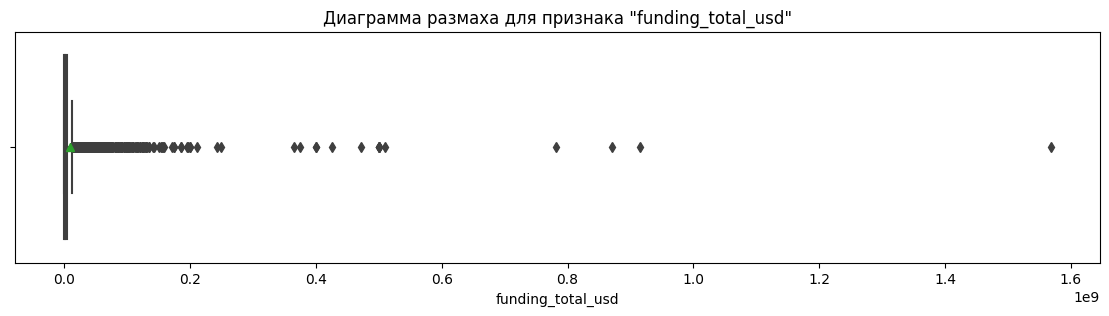

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'funding_total_usd' - до 370000.0.
3. 50% значений 'funding_total_usd' в диапазоне от 370000.0 до 5000000.0.
4. 25% значений 'funding_total_usd' превышают 5000000.0.
5. Медиана 1300000.0
6. Среднее 9200480.95
None
None


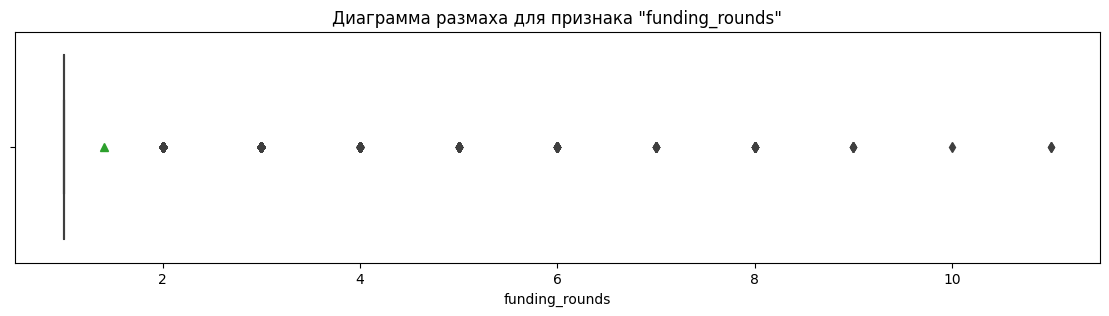

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'funding_rounds' - до 1.0.
3. 50% значений 'funding_rounds' в диапазоне от 1.0 до 1.0.
4. 25% значений 'funding_rounds' превышают 1.0.
5. Медиана 1.0
6. Среднее 1.4
None
None


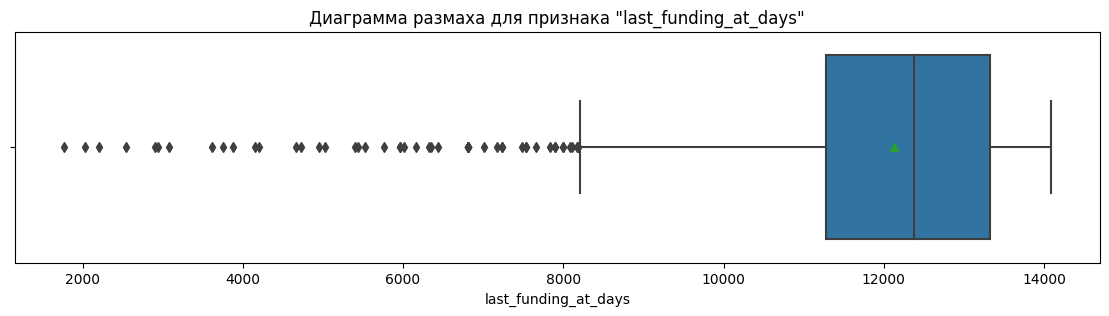

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'last_funding_at_days' - до 11279.0.
3. 50% значений 'last_funding_at_days' в диапазоне от 11279.0 до 13329.0.
4. 25% значений 'last_funding_at_days' превышают 13329.0.
5. Медиана 12374.0
6. Среднее 12124.41
None
None


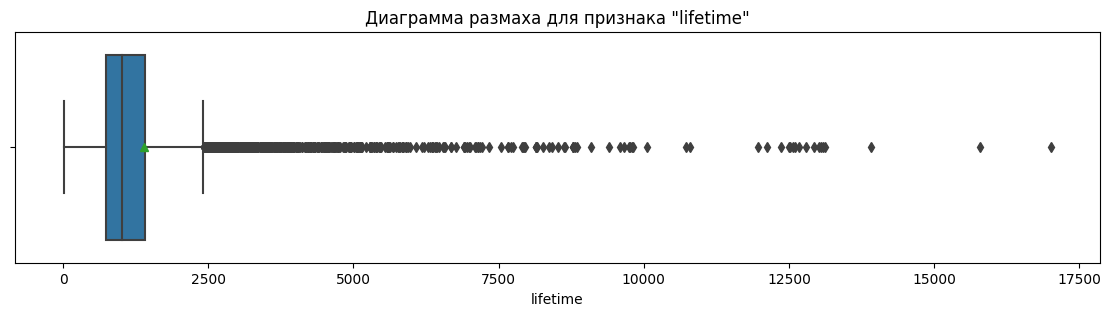

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'lifetime' - до 735.0.
3. 50% значений 'lifetime' в диапазоне от 735.0 до 1407.0.
4. 25% значений 'lifetime' превышают 1407.0.
5. Медиана 1013.0
6. Среднее 1399.25
None
None


In [954]:
# Проведем стат анализ числовых признаков закрывшихся стартапов
num_coll_boxplot(startups_train_close)

Text(0.5, 0, 'шт')

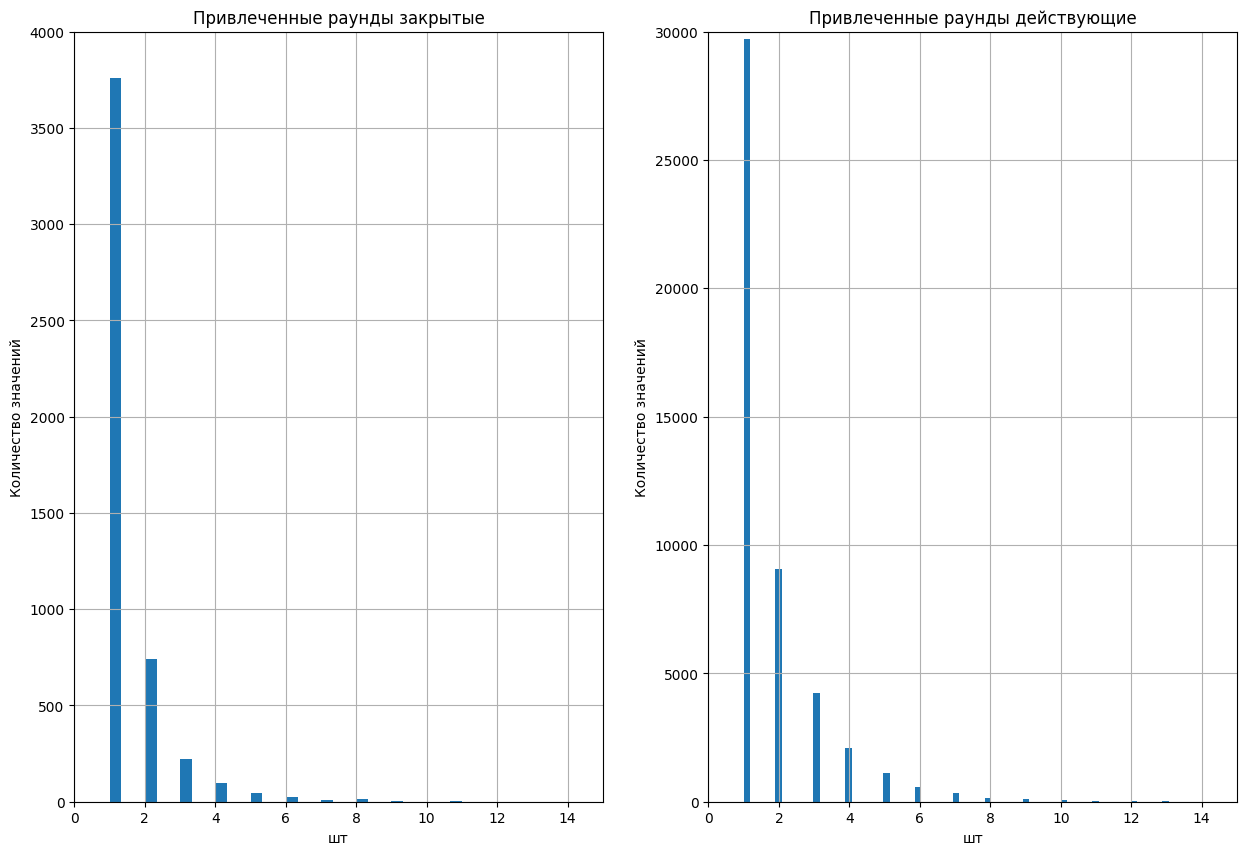

In [955]:
# Сравним распределения по суммам финансирования для закрытых и действующих стартапов. Создаем холст и оси для 2 подграфиков
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

# График "сумма финансирования в USD закрытые"
startups_train_close['funding_rounds'].plot(kind='hist', grid=True,
bins=30, ylim=(0, 4000), xlim=(0, 15), ax=ax[0], legend=False)
ax[0].set_title('Привлеченные раунды закрытые')
ax[0].set_ylabel('Количество значений')
ax[0].set_xlabel('шт')

# График "сумма финансирования в USD действующие"
startups_train_open['funding_rounds'].plot(kind='hist', grid=True,
bins=100, ylim=(0, 30000), xlim=(0, 15), ax=ax[1], legend=False)
ax[1].set_title('Привлеченные раунды действующие')
ax[1].set_ylabel('Количество значений')
ax[1].set_xlabel('шт')

Text(0.5, 0, 'шт')

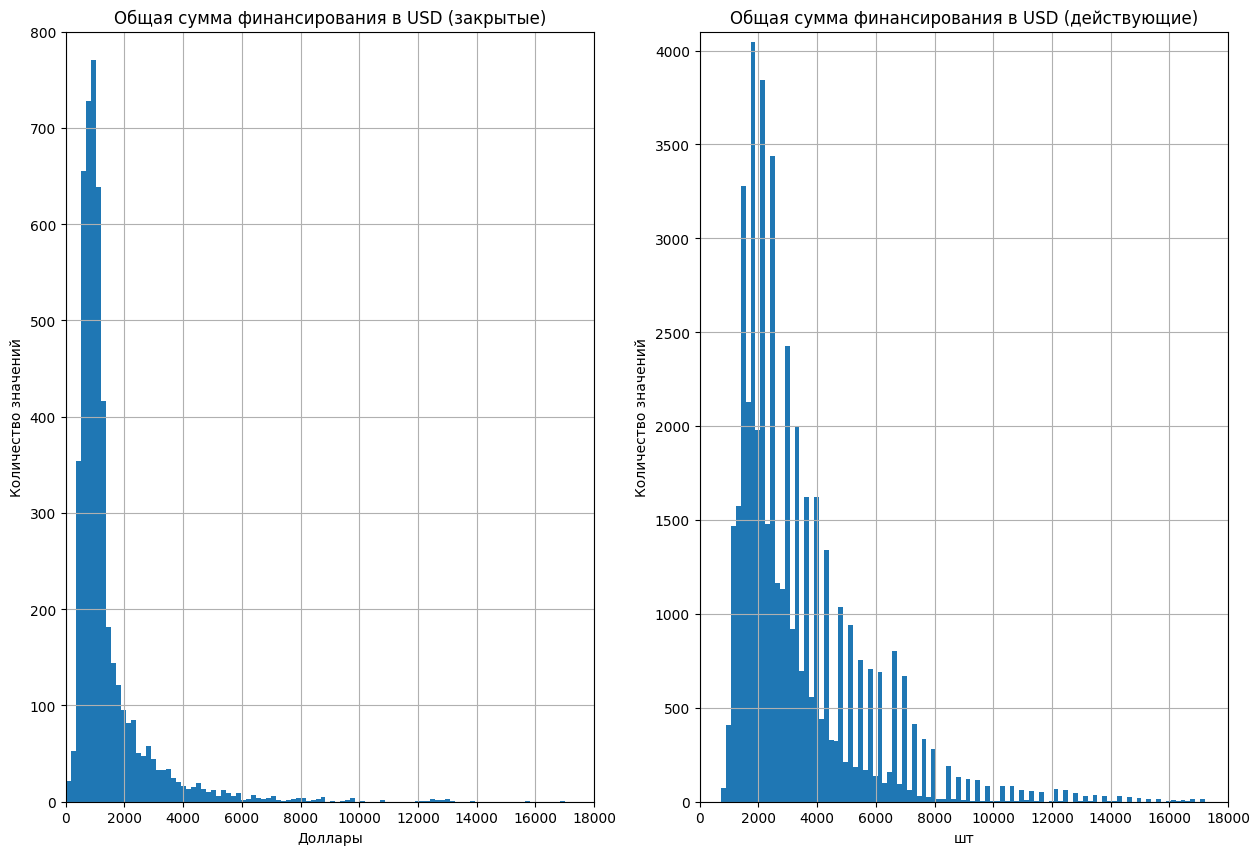

In [956]:
# Сравним распределения по суммам финансирования для закрытых и действующих стартапов. Создаем холст и оси для 2 подграфиков
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

# График "сумма финансирования в USD закрытые"
startups_train_close['lifetime'].plot(kind='hist', grid=True,
bins=100, ylim=(0, 800), xlim=(0, 18000), ax=ax[0], legend=False)
ax[0].set_title('Общая сумма финансирования в USD (закрытые)')
ax[0].set_ylabel('Количество значений')
ax[0].set_xlabel('Доллары')

# График "сумма финансирования в USD действующие"
startups_train_open['lifetime'].plot(kind='hist', grid=True,
bins=100, ylim=(0, 4100), xlim=(0, 18000), ax=ax[1], legend=False)
ax[1].set_title('Общая сумма финансирования в USD (действующие)')
ax[1].set_ylabel('Количество значений')
ax[1].set_xlabel('шт')

Итого по разделу:  

Анализ в разрезе целевого признака:  

funding_total_usd  
1.1 funding_total_usd для закрытых  

Есть значения выходящие за правый дов интервал.  
50% значений 'funding_total_usd' в диапазоне от 370000.0 до 5000000.0.  
Медиана 1300000.0  
Среднее 9203495.11  
1.2 funding_total_usd для действующих:  

Есть значения выходящие за правый дов интервал.  
50% значений 'funding_total_usd' в диапазоне от 560000.0 до 7000000.0.  
Медиана 2000000.0   
Среднее 15730005.81  
2 funding_rounds  

2.1. funding_rounds для закрытых  

Есть значения выходящие за правый дов интервал.  
50% значений 'funding_rounds' = 1  
Медиана 1.0  
Среднее 1.4  
2.2. funding_rounds для действующих:  

Есть значения выходящие за правый дов интервал.  
50% значений 'funding_rounds' в диапазоне от 1.0 до 2.0.  
Медиана 1.0  
Среднее 1.78  
last_funding_at_days  
3.1. last_funding_at_days для закрытых:  

50% значений 'last_funding_at_days' в диапазоне от 11279.0 до 13330.0.  
Медиана 12374.0  
Среднее 12124.25  
3.2. last_funding_at_days для действующих:  

50% значений 'last_funding_at_days' в диапазоне от 12449.0 до 13714.0.  
Медиана 13303.0  
Среднее 12900.34  
lifetime
4.1. lifetime для закрытых:  

50% значений 'lifetime' в диапазоне от 735.0 до 1410.0.   
Медиана 1011.0  
Среднее 1398.58  
4.1. lifetime для действующих:  

50% значений 'lifetime' в диапазоне от 1826.0 до 4018.0.  
Медиана 2577.0  
Среднее 3320.97

In [957]:
# Посчитаем разницу в днях между последним раундом и датой выгрузки
query_date = pd.to_datetime('2018-01-01')

startups_train['last_funding_current_date'] = (query_date - startups_train['last_funding_at']).dt.days
startups_train.sample()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,yc_category,last_funding_at_days,lifetime,last_funding_current_date
37987,Fatfish Internet Group,Internet|Venture Capital,3220000.0,operating,SGP,NaN,Singapore,Singapore,1,2010-01-01,2014-07-21,2014-07-21,2018-01-01,Unspecified,13581,2922,1260


In [958]:
#Посчитаем соотношение между числом дней с последнего рауда и даты выгрузки / life_time
startups_train['last_funding_lifetime_ratio'] = startups_train['last_funding_current_date']/startups_train['lifetime'] 
startups_train.sample()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,yc_category,last_funding_at_days,lifetime,last_funding_current_date,last_funding_lifetime_ratio
18190,O-RID,Отсутствует,2000000.0,operating,JPN,12,JPN - Other,Beppu,1,2001-01-01,2007-11-01,2007-11-01,2018-01-01,Unspecified,11127,6209,3714,0.598164


In [959]:
# Посчитаем разницу в днях между первым и последним раундом 
startups_train['delta_last_funding_first_funding'] = (startups_train['last_funding_at']-startups_train['first_funding_at']).dt.days
startups_train.sample()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,yc_category,last_funding_at_days,lifetime,last_funding_current_date,last_funding_lifetime_ratio,delta_last_funding_first_funding
47571,Pathmatics (formerly Adomic),Advertising,1700000.0,operating,USA,CA,Los Angeles,Santa Monica,2,2010-11-01,2013-01-10,2014-06-04,2018-01-01,Unspecified,13534,2618,1307,0.499236,510


In [960]:
startups_train['funding_total_usd'] = startups_train['funding_total_usd'].astype (float)

In [961]:
# Посчитаем средний чек привлечения
startups_train['mean_check'] = startups_train['funding_total_usd']/startups_train['funding_rounds']
startups_train.sample()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,yc_category,last_funding_at_days,lifetime,last_funding_current_date,last_funding_lifetime_ratio,delta_last_funding_first_funding,mean_check
31744,Qonf,Mobile,40000.0,operating,CHL,12,Santiago,Santiago,1,2013-01-01,2013-03-14,2013-03-14,2018-01-01,Unspecified,13087,1826,1754,0.96057,0,40000.0


In [962]:
# Посчитаем количество раундов на 1 год существования
year=365
startups_train['round_amounts_per_year'] = startups_train['funding_rounds']/(startups_train['lifetime']/year)
startups_train.sample()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,last_funding_at,closed_at,yc_category,last_funding_at_days,lifetime,last_funding_current_date,last_funding_lifetime_ratio,delta_last_funding_first_funding,mean_check,round_amounts_per_year
10838,Girihlet,Technology,2000000.0,operating,USA,NY,New York City,Brooklyn,2,2014-02-01,...,2015-10-27,2018-01-01,Unspecified,14044,1430,797,0.557343,54,1000000.0,0.51049


In [963]:
# Посчитаем среднюю скорость привлечения денег в день
startups_train['money_per_day'] = startups_train['funding_total_usd']/startups_train['lifetime']
startups_train.sample()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,closed_at,yc_category,last_funding_at_days,lifetime,last_funding_current_date,last_funding_lifetime_ratio,delta_last_funding_first_funding,mean_check,round_amounts_per_year,money_per_day
1544,Events Core,Finance,50000.0,operating,SGP,NaN,Singapore,Singapore,1,2008-01-01,...,2018-01-01,Finance,10823,3653,4018,1.099918,0,50000.0,0.099918,13.68738


In [964]:
# Посчитаем признак, допускающий утечку Разница между датой основания и первым привлечением.
startups_train['founded_at_first_funding'] = (startups_train['first_funding_at'] - startups_train['founded_at']).dt.days
startups_train.sample()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,yc_category,last_funding_at_days,lifetime,last_funding_current_date,last_funding_lifetime_ratio,delta_last_funding_first_funding,mean_check,round_amounts_per_year,money_per_day,founded_at_first_funding
13957,UniQure,Biotechnology|Health Care,78000000.0,operating,NLD,7,Amsterdam,Amsterdam,2,2012-11-01,...,Unspecified,13561,1887,1280,0.678325,357,39000000.0,0.386857,41335.4531,250


In [965]:
check_df(startups_train)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   name                              52516 non-null  object        
 1   category_list                     52516 non-null  object        
 2   funding_total_usd                 52516 non-null  float64       
 3   status                            52516 non-null  object        
 4   country_code                      52516 non-null  object        
 5   state_code                        45753 non-null  object        
 6   region                            46157 non-null  object        
 7   city                              46157 non-null  object        
 8   funding_rounds                    52516 non-null  int64         
 9   founded_at                        52516 non-null  datetime64[ns]
 10  first_funding_at                  

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,yc_category,last_funding_at_days,lifetime,last_funding_current_date,last_funding_lifetime_ratio,delta_last_funding_first_funding,mean_check,round_amounts_per_year,money_per_day,founded_at_first_funding
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,Unspecified,13714,2998,1127,0.375917,1310,4.143130e+05,0.243496,276.392929,561
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,Medical Devices,13435,4748,1406,0.296125,1393,1.073375e+07,0.307498,9042.758846,1949
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,Unspecified,13562,4383,1279,0.291809,681,1.181879e+07,0.249829,8089.523386,2423
3,Sancilio and Company,Health Care,22250000.0,operating,USA,NaN,NaN,NaN,3,2004-01-01,...,Unspecified,13578,5114,1263,0.246969,1051,7.416667e+06,0.214118,4350.801721,2800
4,WireTough Cylinders,Manufacturing,2000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,...,Manufacturing,12680,2791,2161,0.774274,0,2.000000e+06,0.130777,716.589036,630


Разработаны новые синтетические признаки
 - разница в днях между последним раундом и датой выгрузки
 - соотношение между числом дней с последнего рауда и даты выгрузки / life_time
 - разница в днях между первым и последним раундом
 - средний чек привлечения
 - количество раундов на 1 год существования
 - средняя скорость привлечения денег в день
 - Разница между датой основания и первым привлечением. Признак, допускающий утечку (не используется в обучении).

**Корреляционный анализ признаков**


Расчет коэффициентов корреляции между признаками

In [966]:
num_coll_list = startups_train.select_dtypes(include='number').columns.tolist()

Text(0.5, 1.0, 'Тепловая карта корреляции Пирсона')

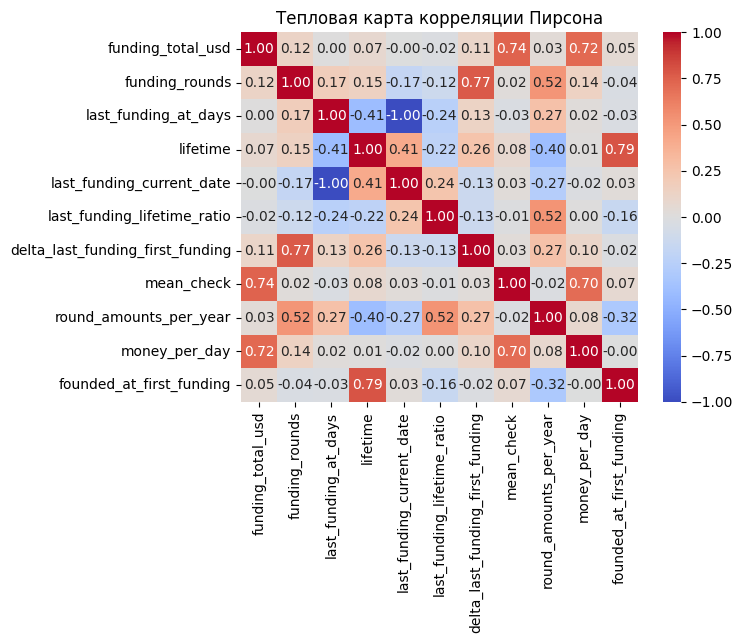

In [967]:
#Построим heatmap с корреляцией признаков
sns.heatmap(startups_train[num_coll_list].corr(), annot=True, cmap='coolwarm', fmt=".2f") 
plt.title('Тепловая карта корреляции Пирсона')

Корреляция и мультиколлинеарность между числовыми признаками отсутстует. В виду того, что на прошлом шаге мы обнаружили выбивающиеся значения оценим корреляцию Спирмана.

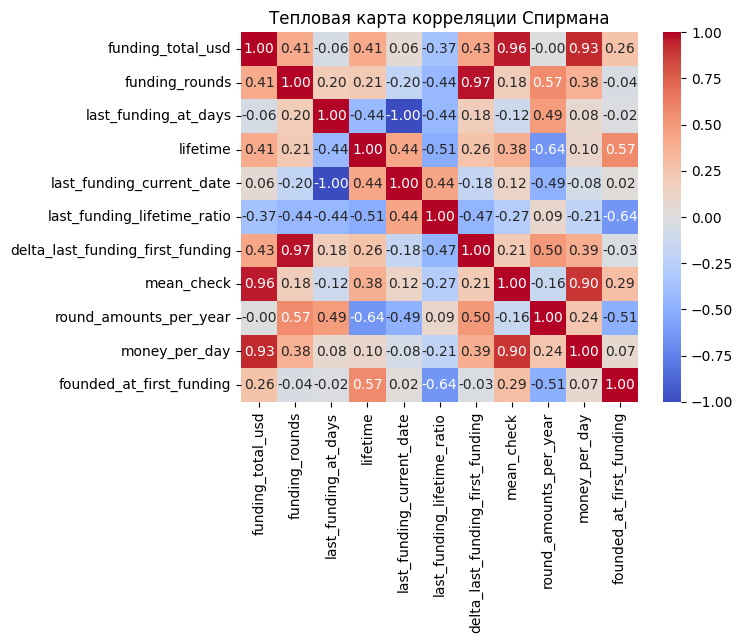

In [968]:
sns.heatmap(startups_train[num_coll_list].corr(method='spearman'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта корреляции Спирмана')
plt.show()

Наблюдаем мультиколлинеарность между сл. признаками:

funding_total_usd и mean_check
funding_rounds и delta_last_funding_first_funding

In [969]:
startups_train['country_code'].nunique()

134

In [970]:
startups_train_small, _ = train_test_split(
    startups_train,
    train_size=500,
    stratify=startups_train['status'],
    random_state=42
)

In [971]:
startups_train_small = startups_train_small.drop('name', axis=1)
startups_train_small.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 50068 to 1806
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   category_list                     500 non-null    object        
 1   funding_total_usd                 500 non-null    float64       
 2   status                            500 non-null    object        
 3   country_code                      500 non-null    object        
 4   state_code                        429 non-null    object        
 5   region                            440 non-null    object        
 6   city                              440 non-null    object        
 7   funding_rounds                    500 non-null    int64         
 8   founded_at                        500 non-null    datetime64[ns]
 9   first_funding_at                  500 non-null    datetime64[ns]
 10  last_funding_at                   500 non-null    

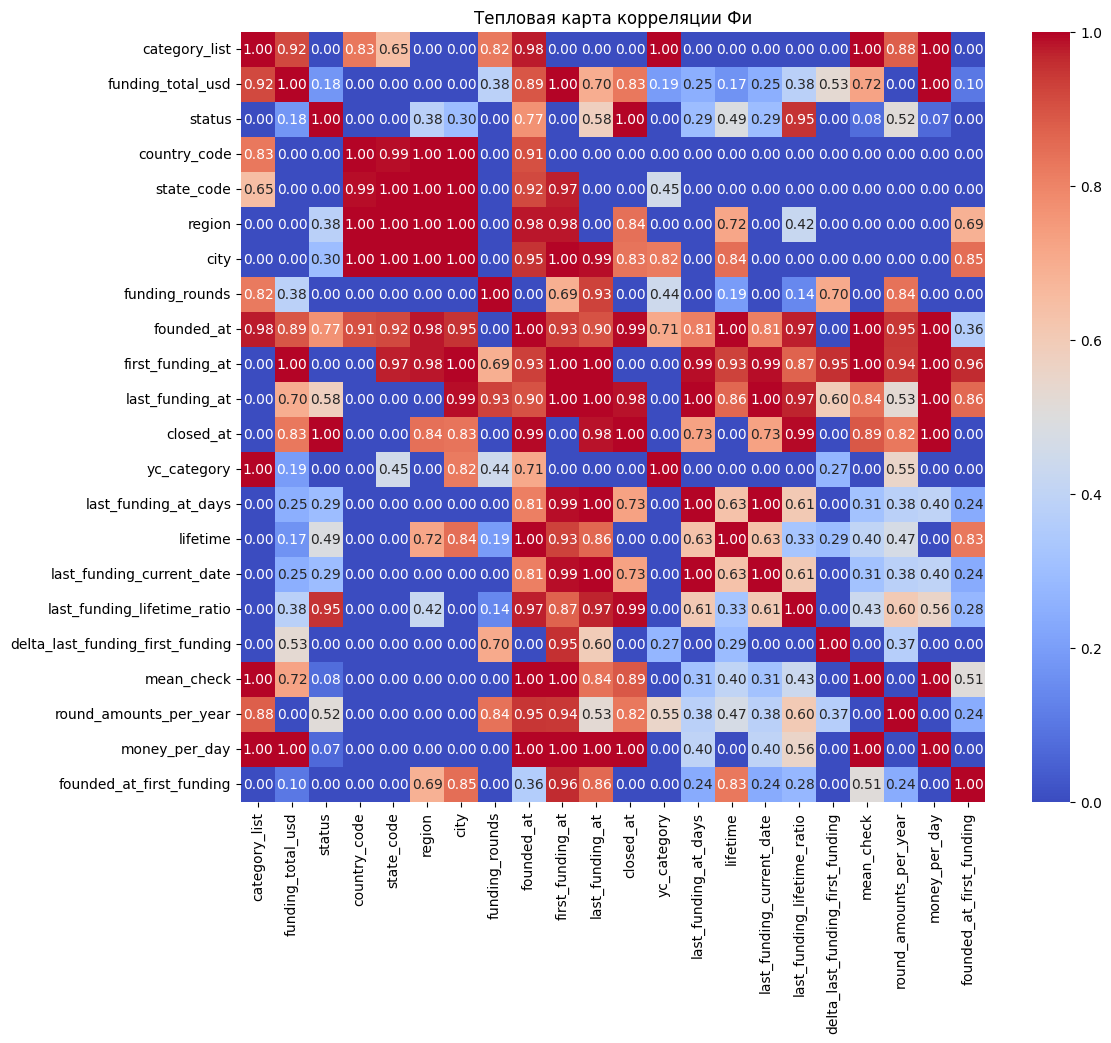

In [972]:
#Построим матрицу корреции Фи для анализа корреляции в том числе категориальных признаков на целевой
phik_matrix = startups_train_small.phik_matrix(interval_cols=num_coll_list)
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта корреляции Фи')
plt.show()

Выводы по итогам раздела:
мультиколлинеарность между признаками state_code, country_code, city, region (корреляция = 1). Целесообразно оставить в качестве входящего признак с наименьним числом уникальных значений (country_code) и наименьшим количеством пропусков, удалим 2 оставшихся.  
мультиколлинеарность между признаками first_funding_at_days и last_funding_at. Целесообразно last_funding_at оставить в качестве входящего признака с наибольшей корреляей с целевым  
мультиколлинеарность между признаками last_funding_at_days и last_funding_current_date. Целесообразно last_funding_at_days оставить в качестве входящего признака с наибольшей корреляей с целевым.  
устойчивую корреляцию целевого признака с производным признаком last_funding_lifetime_ration (0.75).  
умеренную корреляцию целевого признака с признаком lifetime (Фи 0,5), last_funding_at(0,59), founded_at (0,5)

**Отбор финального набора обучающих признаков**
По итогам предыдущего раздела удалим из из датасетов следующие столбцы:

- name - ключ
- state_code - мультиколлинеарный признак  
- city - мультиколлинеарный признак 
- region - мультиколлинеарный признак 
- founded_at - во избежание утечки целевой переменной
- closed_at - отсутствует в тестовой выборке
- category_list - заменили на yc_category в виду большого числа уникальных значений 
- first_funding_at -мультиколлинеарный признак
- last_funding_at, его  заменили на last_funding_at_days
- mean_check - мультиколлинеарный признак с funding_total_usd
- delta_last_funding_first_funding мультиколлинеарный признак с funding_rounds и last_funding_at_days в сочетании с founded_at_first_funding дает утечку целевой переменной.
- last_funding_current_date  мультиколлинеарный признак с last_funding_at_days
- founded_at_first_funding мультиколлинеарный признак с last_funding_current_date

In [973]:
columns_to_drop = ['name', 'state_code', 'city', 'region', 'founded_at', 'closed_at', 'category_list', 'first_funding_at', 'last_funding_at', 'mean_check', 'delta_last_funding_first_funding', 'last_funding_current_date', 'founded_at_first_funding']

In [974]:
startups_train_pipe = startups_train.drop(columns_to_drop, axis=1)

In [975]:
# Закодируем целевой признак 
def y_to_binary(i): 
    if i=='closed':
        return 1
    else:
        return 0

In [976]:
#Применим функцию для преобразования целевого признака в числовой
startups_train_pipe['status'] = startups_train_pipe['status'].apply(y_to_binary) 

In [977]:
startups_train_pipe.sample(10)

,funding_total_usd,status,country_code,funding_rounds,yc_category,last_funding_at_days,lifetime,last_funding_lifetime_ratio,round_amounts_per_year,money_per_day
15084,1000000.0,0,USA,1,Payments,13452,1801,0.771238,0.202665,555.247085
18535,1286600.0,0,USA,1,Unspecified,13164,2687,0.624116,0.135839,478.823967
17893,1200000.0,0,USA,1,Unspecified,13638,1494,0.805221,0.244311,803.212851
7519,355003.0,0,CHL,3,Unspecified,13624,1936,0.628616,0.565599,183.369318
44036,100000.0,0,POL,1,Analytics,10731,4475,0.918436,0.081564,22.346369
42444,3700000.0,0,CHN,2,Legal,13855,1341,0.735272,0.544370,2759.134974
29761,46250000.0,0,USA,6,Real Estate,14065,1826,0.424973,1.199343,25328.587076
26773,146000000.0,0,USA,3,Unspecified,12273,8401,0.305678,0.130342,17378.883466
26656,85000000.0,0,USA,2,Unspecified,13185,4748,0.348778,0.153749,17902.274642
41170,2000000.0,0,USA,1,Content,13394,1436,1.007660,0.254178,1392.757660


In [978]:
startups_train_small, _ = train_test_split(
    startups_train_pipe,
    train_size=1000,
    stratify=startups_train_pipe['status'],
    random_state=42
)

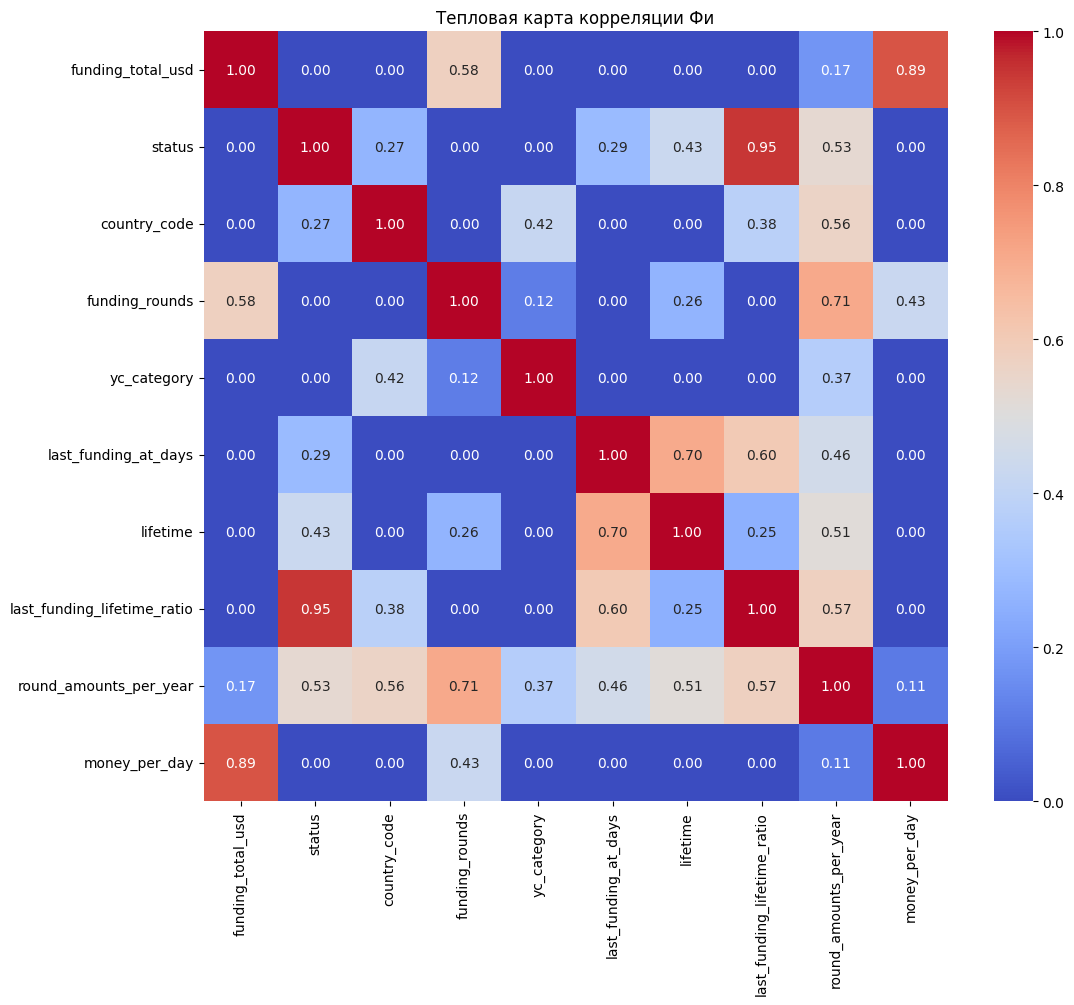

In [979]:
phik_matrix = startups_train_small.phik_matrix(interval_cols=num_coll_list)
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта корреляции Фи')
plt.show()


In [980]:
check_df(startups_train_pipe)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   funding_total_usd            52516 non-null  float64
 1   status                       52516 non-null  int64  
 2   country_code                 52516 non-null  object 
 3   funding_rounds               52516 non-null  int64  
 4   yc_category                  52516 non-null  object 
 5   last_funding_at_days         52516 non-null  int64  
 6   lifetime                     52516 non-null  int64  
 7   last_funding_lifetime_ratio  52516 non-null  float64
 8   round_amounts_per_year       52516 non-null  float64
 9   money_per_day                52516 non-null  float64
dtypes: float64(4), int64(4), object(2)
memory usage: 4.0+ MB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
В датафре

,funding_total_usd,status,country_code,funding_rounds,yc_category,last_funding_at_days,lifetime,last_funding_lifetime_ratio,round_amounts_per_year,money_per_day
0,828626.0,0,CHE,2,Unspecified,13714,2998,0.375917,0.243496,276.392929
1,42935019.0,0,USA,4,Medical Devices,13435,4748,0.296125,0.307498,9042.758846
2,35456381.0,0,USA,3,Unspecified,13562,4383,0.291809,0.249829,8089.523386
3,22250000.0,0,USA,3,Unspecified,13578,5114,0.246969,0.214118,4350.801721
4,2000000.0,0,USA,1,Manufacturing,12680,2791,0.774274,0.130777,716.589036


In [981]:
#Удалим образовавшиеся явные дубликаты
startups_train_pipe = startups_train_pipe.drop_duplicates()
check_df(startups_train_pipe)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
Index: 52315 entries, 0 to 52515
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   funding_total_usd            52315 non-null  float64
 1   status                       52315 non-null  int64  
 2   country_code                 52315 non-null  object 
 3   funding_rounds               52315 non-null  int64  
 4   yc_category                  52315 non-null  object 
 5   last_funding_at_days         52315 non-null  int64  
 6   lifetime                     52315 non-null  int64  
 7   last_funding_lifetime_ratio  52315 non-null  float64
 8   round_amounts_per_year       52315 non-null  float64
 9   money_per_day                52315 non-null  float64
dtypes: float64(4), int64(4), object(2)
memory usage: 4.4+ MB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
Явные дубликат

,funding_total_usd,status,country_code,funding_rounds,yc_category,last_funding_at_days,lifetime,last_funding_lifetime_ratio,round_amounts_per_year,money_per_day
0,828626.0,0,CHE,2,Unspecified,13714,2998,0.375917,0.243496,276.392929
1,42935019.0,0,USA,4,Medical Devices,13435,4748,0.296125,0.307498,9042.758846
2,35456381.0,0,USA,3,Unspecified,13562,4383,0.291809,0.249829,8089.523386
3,22250000.0,0,USA,3,Unspecified,13578,5114,0.246969,0.214118,4350.801721
4,2000000.0,0,USA,1,Manufacturing,12680,2791,0.774274,0.130777,716.589036


In [982]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    startups_train_pipe.drop('status', axis=1),
    startups_train_pipe['status'],
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=startups_train_pipe['status']
)

In [983]:
X_train.shape, X_test.shape

((39236, 9), (13079, 9))

In [984]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test) 

In [985]:
y_train = label_encoder.fit_transform(-y_train)
y_train

array([1, 1, 1, ..., 1, 0, 1])

In [986]:
y_test = label_encoder.transform(-y_test)
y_test

array([1, 1, 1, ..., 1, 1, 1])

In [987]:
ohe_columns = X_train.select_dtypes(include='object').columns.to_list()
ohe_columns

['country_code', 'yc_category']

In [988]:
num_columns = X_train.select_dtypes(include=np.number).columns.to_list()
num_columns

['funding_total_usd',
 'funding_rounds',
 'last_funding_at_days',
 'lifetime',
 'last_funding_lifetime_ratio',
 'round_amounts_per_year',
 'money_per_day']

In [989]:
# пайплайн для подготовки признаков из списка num_columns: заполнение пропусков и масштабирование
# SimpleImputer + Scaler

num_pipe = Pipeline(
    [
        (
            'imputer', 
            SimpleImputer(strategy='median')
        ),
        (
            'scaler', 
            MinMaxScaler()
        )
    ]
)

In [990]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [991]:
data_preprocessor = ColumnTransformer(
    [('num', num_pipe, num_columns),
     ('ohe', ohe_pipe, ohe_columns)     
    ]
)

In [992]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [993]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
]

In [994]:
random_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [995]:
random_search.fit(X_train, y_train)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categ

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['funding_total_usd',
                                                                                'funding_rounds',
                                                                                'last_funding_at_days',
                                                                                'lifetime',
                                                                                'last_funding_lifetime_ratio',
                                                                                'round_amounts_per_year',
                                                                                'money_per_day']),
                                                                              ('ohe',
                                                                               Pipe...
                                         'models__max_depth': range(2, 10),
                                         'models__max_features': range(2, 10),
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']},
                                        {'models': [LogisticRegression(C=9,
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 10),
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [996]:
y_train_pred = random_search.best_estimator_.fit(X_train, y_train).predict(X_train) #предсказанные значения классов
y_train_pred_prob = random_search.best_estimator_.predict_proba(X_train)[:,1]
y_train_pred_prob[:10]

array([0.99740926, 0.83241948, 0.99429792, 0.99573678, 0.93296237,
       0.99514838, 0.99710246, 0.99946315, 0.9957971 , 0.99436128])

In [997]:
print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', random_search.best_score_)
print(f'Метрика ROC-AUC на тренировочной выборке: {roc_auc_score(y_train, y_train_pred_prob)}')
print(f'Метрика F1 на тренировочной выборке: {f1_score(y_train, y_train_pred, average="macro")}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['funding_total_usd',
                                                   'funding_rounds',
                                                   'last_funding_at_days',
                                                   'lifetime',
                                                   'last_funding_lifetime_ratio',
                                                   'round_amounts_per_year',
                                                   'money_per_day']),
                         

Благодаря использованию пайплайна и инструмента подбора гиперпараметров для каждой модели отдельно, выявлена лучшая модель - LogisticRegression(C=9, penalty='l1', random_state=42,
                                    solver='liblinear'). Метрика F1-score для этой модели: 0.90.

In [998]:
y_test_pred = random_search.predict(X_test)
print(f'Метрика f1 на тестовой выборке: {f1_score(y_test, y_test_pred)}')

Метрика f1 на тестовой выборке: 0.985070892410342


In [999]:
pd.DataFrame(random_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num__scaler,param_models__max_features,param_models__max_depth,param_models,param_models__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.359604,0.014567,0.061954,0.007235,MinMaxScaler(),5,8,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num__scaler': MinMaxScaler(), ...",0.589294,0.896394,0.853880,0.768594,0.830288,0.787690,0.107460,6
1,0.348393,0.008284,0.047849,0.002024,StandardScaler(),9,5,DecisionTreeClassifier(random_state=42),NaN,{'preprocessor__num__scaler': StandardScaler()...,0.831561,0.847991,0.782536,0.930391,0.902056,0.858907,0.052290,5
2,3.166958,0.513967,0.049384,0.001172,StandardScaler(),NaN,NaN,"LogisticRegression(C=9, penalty='l1', random_s...",9,{'preprocessor__num__scaler': StandardScaler()...,0.934403,0.932593,0.937952,0.939235,0.925706,0.933978,0.004774,1
3,9.177713,0.642827,0.049562,0.001526,MinMaxScaler(),NaN,NaN,"LogisticRegression(C=9, penalty='l1', random_s...",9,"{'preprocessor__num__scaler': MinMaxScaler(), ...",0.934173,0.932759,0.937886,0.939381,0.925584,0.933957,0.004826,3
4,0.309618,0.006672,0.050335,0.005046,StandardScaler(),7,2,DecisionTreeClassifier(random_state=42),NaN,{'preprocessor__num__scaler': StandardScaler()...,0.590946,0.878945,0.599307,0.533331,0.513636,0.623233,0.131983,10
5,0.311352,0.010017,0.051723,0.005901,passthrough,4,6,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num__scaler': 'passthrough', '...",0.608687,0.566181,0.616178,0.573476,0.886592,0.650223,0.119756,8
6,0.317466,0.007567,0.051063,0.005133,StandardScaler(),3,9,DecisionTreeClassifier(random_state=42),NaN,{'preprocessor__num__scaler': StandardScaler()...,0.679163,0.756524,0.791021,0.583247,0.771694,0.716330,0.076619,7
7,7.576335,0.969499,0.044051,0.008677,MinMaxScaler(),NaN,NaN,"LogisticRegression(C=9, penalty='l1', random_s...",6,"{'preprocessor__num__scaler': MinMaxScaler(), ...",0.934421,0.932741,0.937759,0.939193,0.925746,0.933972,0.004711,2
8,0.302114,0.005247,0.049274,0.000924,StandardScaler(),3,5,DecisionTreeClassifier(random_state=42),NaN,{'preprocessor__num__scaler': StandardScaler()...,0.552458,0.575057,0.648280,0.555220,0.899990,0.646201,0.131560,9
9,0.352799,0.006458,0.049574,0.001658,StandardScaler(),9,7,DecisionTreeClassifier(random_state=42),NaN,{'preprocessor__num__scaler': StandardScaler()...,0.839776,0.858347,0.892273,0.930573,0.913604,0.886915,0.033720,4


Формирование предсказаний на тестовом датасете

In [1000]:
startups_test.sample()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,yc_category,last_funding_at_days
11811,Onyu,Apps|Contact Management|CRM|Deep Information T...,2000000.0,GBR,U8,Edinburgh,Edinburgh,1,2014-02-18,2014-02-18,1413,Security,14919


In [1001]:
startups_test['last_funding_current_date'] = (query_date - startups_test['last_funding_at']).dt.days
startups_test.sample()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,yc_category,last_funding_at_days,last_funding_current_date
2685,Docin,Curated Web,2000000.0,CHN,22,Beijing,Beijing,2,2010-11-01,2011-05-01,4018,Unspecified,13895,2437


In [1002]:
#Посчитаем соотношение между числом дней с последнего рауда и даты выгрузки / life_time
startups_test['last_funding_lifetime_ratio'] = startups_test['last_funding_current_date']/startups_test['lifetime'] 
startups_test.sample()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,yc_category,last_funding_at_days,last_funding_current_date,last_funding_lifetime_ratio
11302,Hutchison MediPharma,Health Care,20200000.0,CHN,23,Shanghai,Shanghai,2,2010-11-08,2010-12-21,2806,Unspecified,13764,2568,0.915182


In [1003]:
# Посчитаем количество раундов на 1 год существования
startups_test['round_amounts_per_year'] = startups_test['funding_rounds']/(startups_test['lifetime']/year)
startups_test.sample()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,yc_category,last_funding_at_days,last_funding_current_date,last_funding_lifetime_ratio,round_amounts_per_year
7890,StylePuzzle,Fashion|Lifestyle|Shopping,1000000.0,USA,CA,SF Bay Area,San Francisco,2,2014-06-13,2014-12-01,1310,Unspecified,15205,1127,0.860305,0.557252


In [1004]:
startups_test['funding_total_usd'] = startups_test['funding_total_usd'].astype (float)

In [1005]:
# Посчитаем среднюю скорость привлечения денег в день
startups_test['money_per_day'] = startups_test['funding_total_usd']/startups_test['lifetime']
startups_test.sample()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,yc_category,last_funding_at_days,last_funding_current_date,last_funding_lifetime_ratio,round_amounts_per_year,money_per_day
8375,Vision-Box,Information Technology,2000000.0,PRT,14,Lisbon,Lisbon,1,2015-11-13,2015-11-13,6209,Unspecified,15552,780,0.125624,0.058786,322.113062


In [1006]:
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   name                         13125 non-null  object        
 1   category_list                13125 non-null  object        
 2   funding_total_usd            13125 non-null  float64       
 3   country_code                 13125 non-null  object        
 4   state_code                   11430 non-null  object        
 5   region                       11536 non-null  object        
 6   city                         11538 non-null  object        
 7   funding_rounds               13125 non-null  int64         
 8   first_funding_at             13125 non-null  datetime64[ns]
 9   last_funding_at              13125 non-null  datetime64[ns]
 10  lifetime                     13125 non-null  int64         
 11  yc_category                  13125 non-nu

In [1007]:
columns_to_drop = ['name',
                   'state_code', 
                   'city', 
                   'region',
                   'category_list',
                   'first_funding_at', 'last_funding_at', 'last_funding_current_date'
                  ]

In [1008]:
startups_test_final = startups_test.drop(columns_to_drop, axis=1)

In [1009]:
check_df(startups_test_final)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   funding_total_usd            13125 non-null  float64
 1   country_code                 13125 non-null  object 
 2   funding_rounds               13125 non-null  int64  
 3   lifetime                     13125 non-null  int64  
 4   yc_category                  13125 non-null  object 
 5   last_funding_at_days         13125 non-null  int64  
 6   last_funding_lifetime_ratio  13125 non-null  float64
 7   round_amounts_per_year       13125 non-null  float64
 8   money_per_day                13125 non-null  float64
dtypes: float64(4), int64(3), object(2)
memory usage: 923.0+ KB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
В датафрейме найдено 17 явных дубликатов.


,funding_total_usd,country_code,funding_rounds,lifetime,yc_category,last_funding_at_days,last_funding_lifetime_ratio,round_amounts_per_year,money_per_day
0,2819200.0,NIC,1,3501,Unspecified,13226,0.887175,0.104256,805.255641
1,2000000.0,USA,1,2717,Unspecified,13618,0.998896,0.134339,736.105999
2,428257.0,LUX,2,1295,Finance,15131,0.927413,0.563707,330.700386
3,34700000.0,USA,4,4748,Unspecified,13519,0.592460,0.307498,7308.340354
4,4530000.0,CAN,1,6209,Unspecified,12441,0.626671,0.058786,729.586085


In [1010]:

print(X_train.columns)
print(startups_test_final.columns)

Index(['funding_total_usd', 'country_code', 'funding_rounds', 'yc_category',
       'last_funding_at_days', 'lifetime', 'last_funding_lifetime_ratio',
       'round_amounts_per_year', 'money_per_day'],
      dtype='object')
Index(['funding_total_usd', 'country_code', 'funding_rounds', 'lifetime',
       'yc_category', 'last_funding_at_days', 'last_funding_lifetime_ratio',
       'round_amounts_per_year', 'money_per_day'],
      dtype='object')


In [1012]:
startups_test_final = startups_test_final[X_train.columns]
startups_test_final.sample(3)

,funding_total_usd,country_code,funding_rounds,yc_category,last_funding_at_days,lifetime,last_funding_lifetime_ratio,round_amounts_per_year,money_per_day
2115,2.500000e+05,USA,1,Delivery,13561,3129,0.885586,0.116651,79.897731
12065,1.250000e+06,ARE,2,Analytics,13806,3256,0.775799,0.224201,383.906634
5528,1.043300e+09,USA,7,Unspecified,15402,5479,0.169739,0.466326,190417.959482


In [1013]:
predictions = random_search.predict(startups_test_final)

In [1014]:
predictions

array([1, 1, 0, ..., 1, 1, 1])

In [1015]:
startups_test_final['Predictions'] = predictions

In [1016]:
startups_test_final.head(10)

,funding_total_usd,country_code,funding_rounds,yc_category,last_funding_at_days,lifetime,last_funding_lifetime_ratio,round_amounts_per_year,money_per_day,Predictions
0,2819200.0,NIC,1,Unspecified,13226,3501,0.887175,0.104256,805.255641,1
1,2000000.0,USA,1,Unspecified,13618,2717,0.998896,0.134339,736.105999,1
2,428257.0,LUX,2,Finance,15131,1295,0.927413,0.563707,330.700386,0
3,34700000.0,USA,4,Unspecified,13519,4748,0.592460,0.307498,7308.340354,1
4,4530000.0,CAN,1,Unspecified,12441,6209,0.626671,0.058786,729.586085,1
5,160000.0,USA,2,Design,15131,1583,0.758686,0.461150,101.073910,1
6,26842000.0,USA,5,Unspecified,15023,4018,0.325784,0.454206,6680.438029,1
7,4000000.0,USA,1,Therapeutics,11005,5576,0.955344,0.065459,717.360115,1
8,8710000.0,USA,3,Unspecified,15507,1826,0.451807,0.599671,4769.989047,1
9,13200.0,USA,1,Unspecified,14726,2057,0.780749,0.177443,6.417112,1


In [1017]:
startups_test_final = startups_test_final.merge(
    startups_test[['name']], 
    left_index=True, 
    right_index=True
)

In [1018]:
startups_test_final.head(10)

,funding_total_usd,country_code,funding_rounds,yc_category,last_funding_at_days,lifetime,last_funding_lifetime_ratio,round_amounts_per_year,money_per_day,Predictions,name
0,2819200.0,NIC,1,Unspecified,13226,3501,0.887175,0.104256,805.255641,1,Crystalsol
1,2000000.0,USA,1,Unspecified,13618,2717,0.998896,0.134339,736.105999,1,JBI Fish & Wings
2,428257.0,LUX,2,Finance,15131,1295,0.927413,0.563707,330.700386,0,COINPLUS
3,34700000.0,USA,4,Unspecified,13519,4748,0.592460,0.307498,7308.340354,1,Imagine Communications
4,4530000.0,CAN,1,Unspecified,12441,6209,0.626671,0.058786,729.586085,1,DNA13
5,160000.0,USA,2,Design,15131,1583,0.758686,0.461150,101.073910,1,Quickfire Games
6,26842000.0,USA,5,Unspecified,15023,4018,0.325784,0.454206,6680.438029,1,Sente Inc.
7,4000000.0,USA,1,Therapeutics,11005,5576,0.955344,0.065459,717.360115,1,Triosyn
8,8710000.0,USA,3,Unspecified,15507,1826,0.451807,0.599671,4769.989047,1,Urgent.ly
9,13200.0,USA,1,Unspecified,14726,2057,0.780749,0.177443,6.417112,1,Map Decisions


In [1019]:
columns_to_stay=['name', 'Predictions']

In [1020]:
df_submit = startups_test_final[columns_to_stay]
df_submit

,name,Predictions
0,Crystalsol,1
1,JBI Fish & Wings,1
2,COINPLUS,0
3,Imagine Communications,1
4,DNA13,1
...,...,...
13120,Jymob,1
13121,GlobaTrek,1
13122,Inkd.com,1
13123,AdWill,1


In [1021]:
df_submit=df_submit.rename(columns={'Predictions':'status'})
df_submit

,name,status
0,Crystalsol,1
1,JBI Fish & Wings,1
2,COINPLUS,0
3,Imagine Communications,1
4,DNA13,1
...,...,...
13120,Jymob,1
13121,GlobaTrek,1
13122,Inkd.com,1
13123,AdWill,1


In [1022]:
def y_to_text(i): 
    if i==1:
        return 'closed'
    else:
        return 'operating'

In [1023]:
#Применим функцию для преобразования целевого признака в числовой
df_submit['status'] = df_submit['status'].apply(y_to_text) 

In [1024]:
df_submit.sample(20)

,name,status
11377,Jotvine.com,operating
4005,Play With Pictures / HangPic,operating
6833,NewDog Technologies,closed
2035,Einsight Ng Ltd,closed
3339,Backup Circle,operating
3927,"BagnaCauda Co., Ltd.",closed
11684,Palyon Medical,closed
10060,TV Volume Wizard App,closed
3993,Myer,closed
2674,NuVox,closed


In [1026]:
df_submit.to_csv('Polina_shax.csv', index=False)

**Анализ важности признаков лучшей модели**

In [1029]:
param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(2, 5),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [1030]:
X_train.shape

(39236, 9)

In [1031]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categ

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['funding_total_usd',
                                                                                'funding_rounds',
                                                                                'last_funding_at_days',
                                                                                'lifetime',
                                                                                'last_funding_lifetime_ratio',
                                                                                'round_amounts_per_year',
                                                                                'money_per_day']),
                                                                              ('ohe',
                                                                               Pipeline(...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [DecisionTreeClassifier(random_state=42)],
                                         'models__max_depth': range(2, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

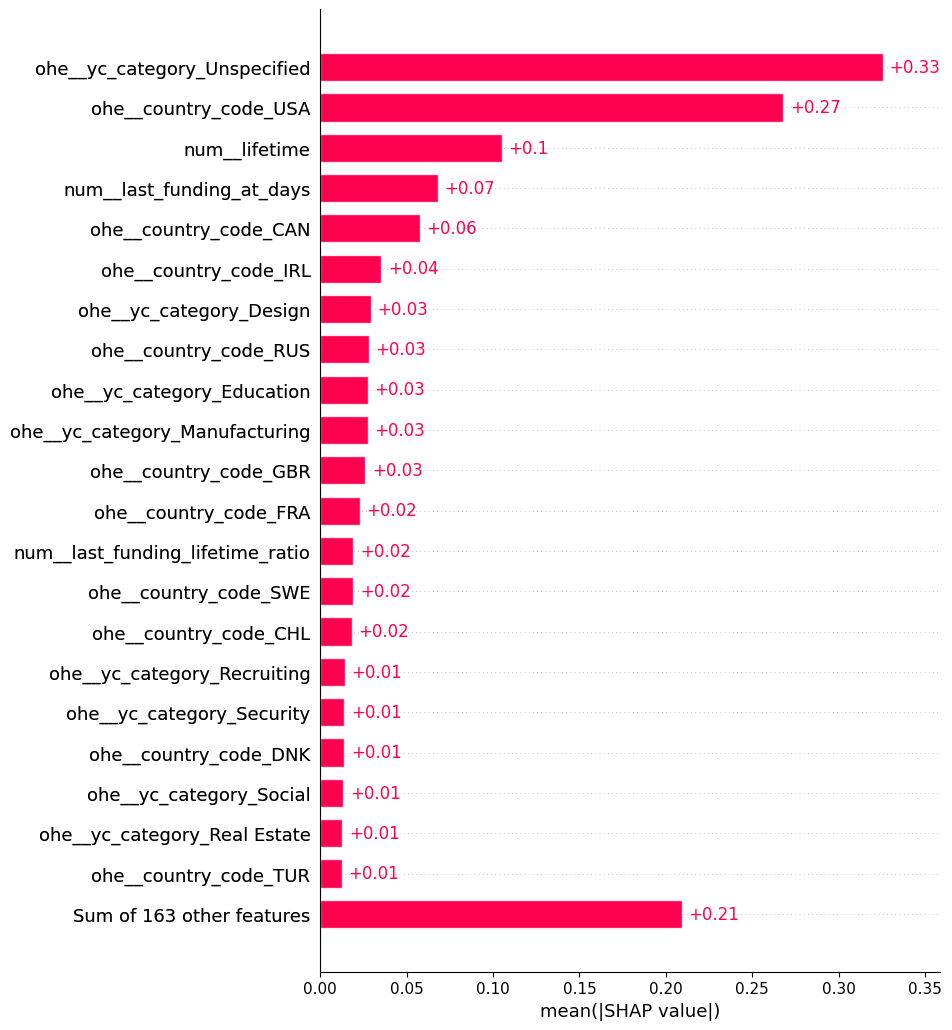

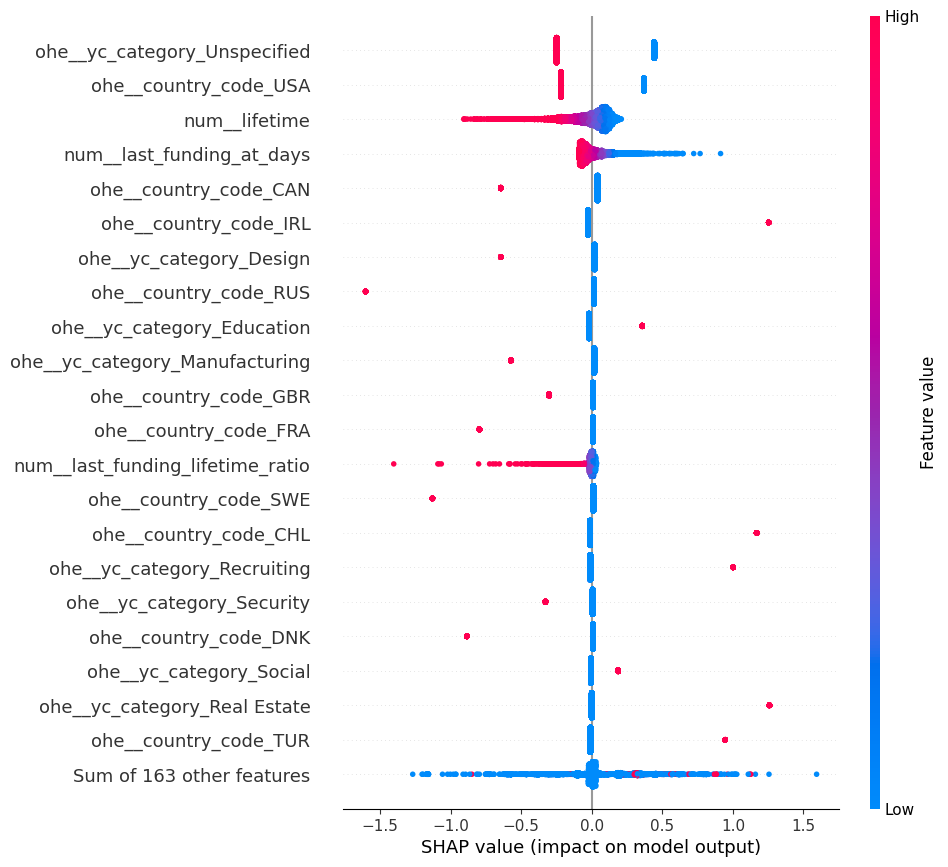

In [1032]:
X_train_best = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_best = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test_best = pd.DataFrame(X_test_best, columns=feature_names)

# Создание объекта Explainer для модели 
explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], X_train_best) 
shap_values = explainer(X_test_best)

# График важности признаков обученной модели логистической регрессии.  
shap.plots.bar(shap_values, max_display=22)
shap.plots.beeswarm(shap_values, max_display=22) 


**Вывод:**
Цель проекта - разработать модель для предсказания успешности стартапа (закроется или нет).

Источники данных

*Тренировочный набор* (около 53к записей). Набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01' kaggle_startups_train_28062024.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.  

*Тестовый набор*. kaggle_startups_test_28062024.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'status' для каждого стартапа из этого датасета. kaggle_startups_sample_submit_28062024.csv - файл с примером предсказаний в правильном формате. name - идентификатор (название) стартапа в тестовом наборе. status - целевой признак. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу ['operating', 'closed'].

Реализованые шаги проекта:

- Загружены данные, проведена проверка признаков описанию.

- Предварительная обработка данных. Устранены пропуски и дубликаты. Форматы приведены в соответствие. Укрупнен категориальный признак category_list данные записаны в столбец yc_category. Данные признака last_funding_at преобразованы в числовой формат и записаны в отдельный столбец last_funding_at_days.

- Разработаны новые синтетические признаки  
разница в днях между последним раундом и датой выгрузки  
соотношение между числом дней с последнего рауда и даты выгрузки / life_time  
разница в днях между первым и последним раундом  
средний чек привлечения  
количество раундов на 1 год существования  
средняя скорость привлечения денег в день  
разница между датой основания и первым привлечением.  

- Проведена проверка признаков на мультиколлинеарность, по итогам которой проведен финальный отбор обучающих признаков.  

- Собран пайплан обработки данных и перебора гиперпараметров.  

- Проведена итоговая оценка качества предсказания лучшей модели на кросс-вадидации.  

- Сформированы предсказания на тестовом датасете  

- Проведен анализ важности признаков лучшей модели.  

- Подготовлен профиль действующего стартапа.

лучшаяя модель LogisticRegression(C=9, penalty='l1', random_state=42,
                                    solver='liblinear')